# Finetunning pretained CNN

In [4]:
import torch



In [3]:
from pathlib import Path
from torchvision.io import read_image
import matplotlib.pyplot as plt

from torchvision.io import read_image
from torchvision.transforms import v2

In [16]:
# import Dataset
import numpy as np
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import tv_tensors
# We create a dataset for binary classification
class GraspDataset(Dataset):
    """
        Grasp verification Dataset
    """
    def __init__(self, pos_path, neg_path, balance=True, transform=None):
        """
            Args:
                pos_path (Path): Path to positive samples
                neg_path (Path): Path to negative samples
                balance (bool): If True, balance the dataset
                transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.pos_path = pos_path
        self.neg_path = neg_path
        self.pos_files = list(pos_path.glob("*.png"))
        # as str
        self.pos_files = [str(p) for p in self.pos_files]
        self.neg_files = list(neg_path.glob("*.png"))
        # as str
        self.neg_files = [str(p) for p in self.neg_files]


        if balance:
            min_len = min(len(self.pos_files), len(self.neg_files))
            self.pos_files = self.pos_files[:min_len]
            self.neg_files = self.neg_files[:min_len]


        self.files = self.pos_files + self.neg_files
        # create equivalent list of idxs
        self.targets = [1]*len(self.pos_files) + [0]*len(self.neg_files)
        # create random permutation
        # self.perm = torch.randperm(len(self.files))
        # self.files = [self.files[i] for i in self.perm]
        # self.targets = [self.targets[i] for i in self.perm]
        self.transform = transform
    def __len__(self):
        return len(self.pos_files) + len(self.neg_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        assert idx < len(self), "Index out of bounds"
        img_path = self.files[idx]

        image = tv_tensors.Image(read_image(img_path))
        target = self.targets[idx]

        
        if self.transform:
            image, target = self.transform(image, target)
        return np.array(image), target


from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []

    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.Resize((224, 224)))
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [17]:
from torch.utils.data import DataLoader
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
pos_path = Path("/home/pmarg/data/positive/imgs")
neg_path = Path("/home/pmarg/data/negative/imgs")
dataset = GraspDataset(pos_path, neg_path, transform=get_transform(train=True))

dataset.__getitem__(0)[0].shape


/home/pmarg/miniconda3/envs/blender/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/home/pmarg/miniconda3/envs/blender/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to we

(3, 224, 224)

tensor([0, 1, 1, 1])


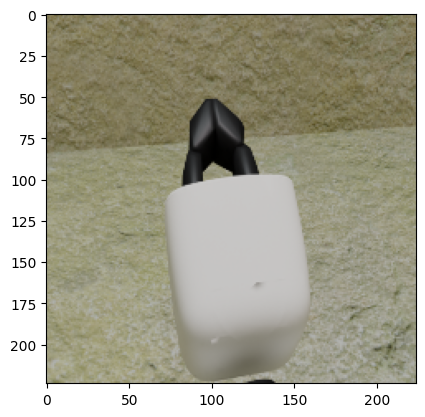

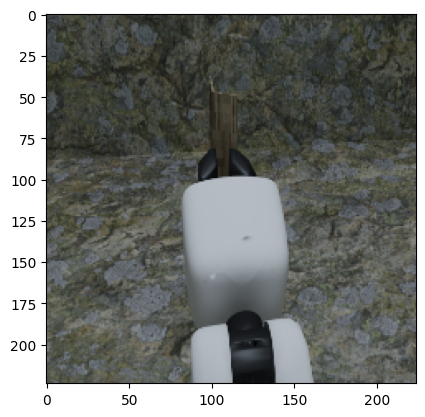

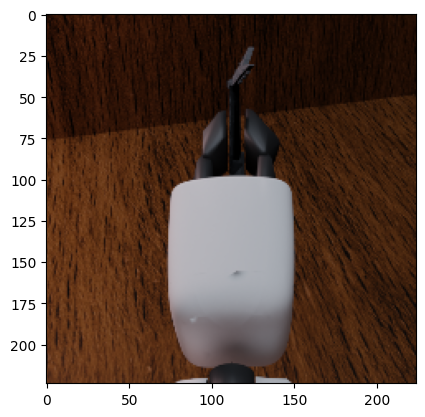

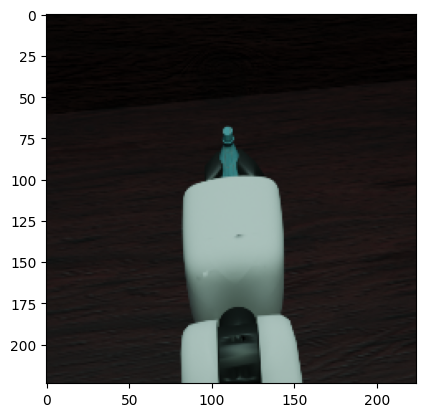

In [18]:

# get lis tof files in pos_path
pos_files = list(pos_path.glob("*.png"))
dataset = GraspDataset(pos_path, neg_path, transform=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# get a batch of data
for i, (imgs, targets) in enumerate(data_loader):
    print(targets)
    for img in imgs:
        plt.imshow(img.permute(1,2,0))
        plt.show()
    break

In [19]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

for param in model.parameters():
    param.requires_grad = False
import torch.nn as nn
model_header = torch.nn.Sequential(
    nn.Linear(512, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)
model.fc = model_header



Using cache found in /home/pmarg/.cache/torch/hub/pytorch_vision_v0.10.0
/home/pmarg/miniconda3/envs/blender/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pmarg/miniconda3/envs/blender/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
dataset = GraspDataset(pos_path, neg_path, transform=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)


# For Training
images, targets = next(iter(data_loader))
output = model(images)  # Returns losses and detections


In [ ]:

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = GraspDataset(pos_path=pos_path, neg_path=neg_path,transform= get_transform(train=True))
dataset_test = GraspDataset(pos_path=pos_path, neg_path=neg_path,transform= get_transform(train=True))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    # train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")


/home/pmarg/miniconda3/envs/blender/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


NameError: name 'train_one_epoch' is not defined